# Задание 5.2

In [16]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'database': 'simulator_20230820',
    'user': 'student',
    'password': 'dpo_python_2020'   
}

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pandahouse
import hashlib
# import swifter
from scipy import stats
%matplotlib inline

In [18]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-07-30' and '2023-08-05'
    and exp_group in (2,1)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

group_A=df[df.exp_group==2].copy()
group_B=df[df.exp_group==1].copy()

In [19]:
stats.ttest_ind(group_A.ctr,
                group_B.ctr,
                equal_var=False)

Ttest_indResult(statistic=-0.4051491913112757, pvalue=0.685373331140751)

In [ ]:
# Нужна дополнительная проверка сглаживанием


In [20]:
def get_smoothed_ctr(user_likes, user_views, global_ctr, alpha):
    smoothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smoothed_ctr

global_ctr_A = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()
global_ctr_B = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()

In [21]:
group_A['smoothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_A, 5), axis=1)

group_B['smoothed_ctr'] = df.apply(
    lambda x: get_smoothed_ctr(x['likes'], x['views'], global_ctr_B, 5), axis=1)

In [23]:
stats.ttest_ind(group_A.smoothed_ctr,
                group_B.smoothed_ctr,
                equal_var=False)

Ttest_indResult(statistic=-1.9460491517027678, pvalue=0.05166679015318533)

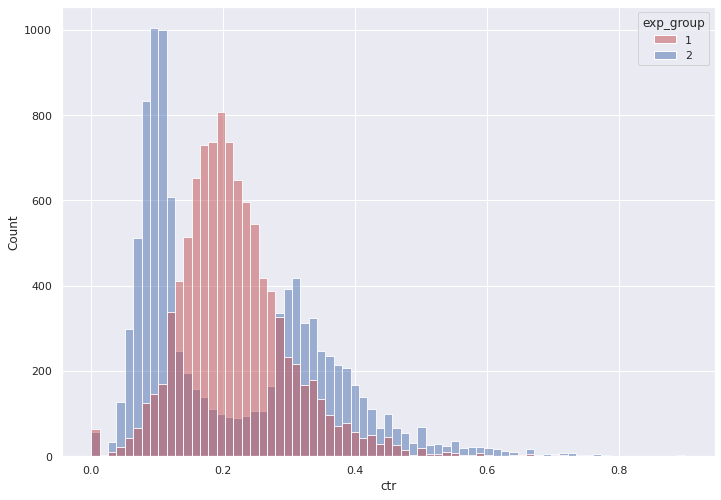

In [24]:
# Построим графики
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [25]:
global_ctr_A, global_ctr_B

(0.20025051027061783, 0.2096041628394293)

In [26]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

In [29]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-07-30' and '2023-08-05'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""


df = pandahouse.read_clickhouse(q, connection=connection)

likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

In [30]:
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

<AxesSubplot:ylabel='Count'>

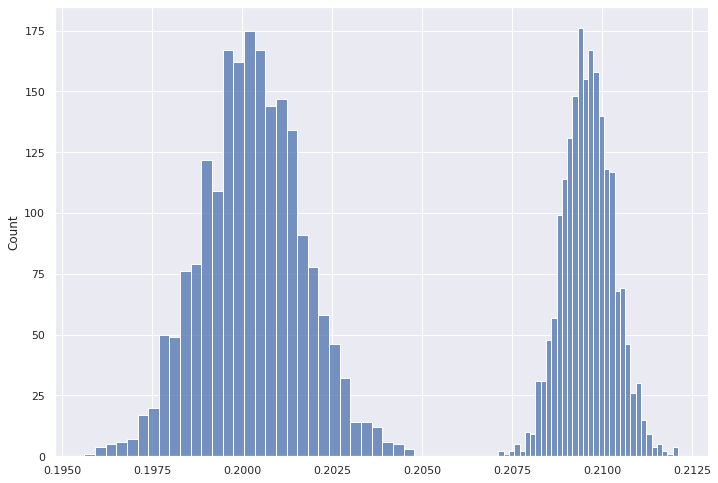

In [31]:
sns.histplot(ctr1)
sns.histplot(ctr2)

In [50]:
q = """

SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as bucket_ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-07-30' and '2023-08-05'
        and exp_group in (1,2)
    
GROUP BY exp_group, bucket
"""

df = pandahouse.read_clickhouse(q, connection=connection)

In [51]:
stats.mannwhitneyu(df[df.exp_group == 1].bucket_ctr, 
                   df[df.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1997.0, pvalue=2.6576427804010095e-07)

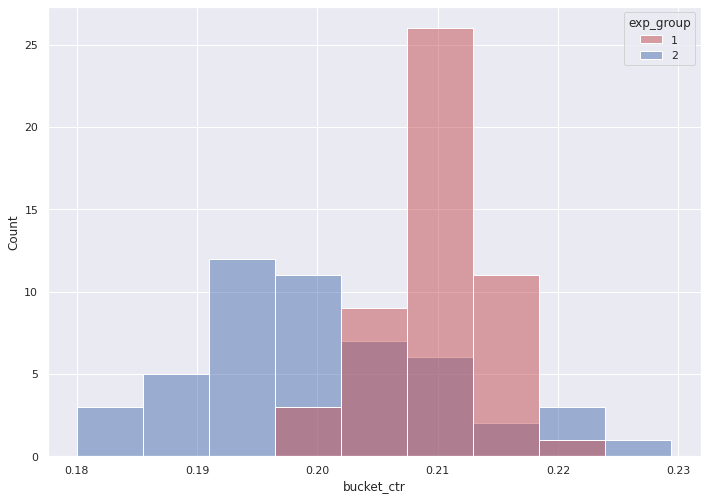

In [52]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df, 
              x='bucket_ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

ВЫВОД: TT-тест, тест Манна Уитни, t-тест на сглаженном ctr (α=5) - показывают различные значения. Значит, нет оснований удтверждать, что нововведение по внедряемым рекомендациям может принести в будущем нужный эффект.